# A quick jupyter notebook to experiment with the FastF1 API endpoints and check data format

### Here's a link to the FastF1 github: https://github.com/theOehrly/Fast-F1

In [1]:
import fastf1
import json

fastf1.Cache.enable_cache("cache")
session = fastf1.get_session(2025, "Suzuka", "Q")
session.load()

core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '12', '6', '44', '23', '87', '10', '55', '14', '30', '22', '27', '5', '31', '7', '18']


In [2]:
suzuka_circuit_info = session.get_circuit_info()
# suzuka_circuit_info.corners

In [3]:
data = {
    "rotation": suzuka_circuit_info.rotation,
    "corners": suzuka_circuit_info.corners.to_numpy().tolist()
}
with open("suzuka_track_info.json", "w") as f:
    json.dump(data, f, indent=2)

In [4]:
best_laps = {}
best_laps["VER"] = session.laps.pick_drivers("VER").pick_fastest()
# best_laps["VER"]

In [5]:
best_laps["PIA"] = session.laps.pick_drivers("PIA").pick_fastest()
# best_laps["PIA"]

In [6]:
tel = best_laps["PIA"].get_telemetry()
print(tel.keys())

Index(['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time',
       'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source',
       'Distance', 'RelativeDistance', 'Status', 'X', 'Y', 'Z'],
      dtype='object')


# Lets actually draw the lap to see how it looks

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import splprep, splev
import numpy as np

In [8]:
with open("ver_suzuka_2025.json") as f:
    data_ver = json.load(f)
    df_ver = pd.DataFrame(data_ver["location"])

with open("pia_suzuka_2025.json") as f:
    data_pia = json.load(f)
    df_pia = pd.DataFrame(data_pia["location"])

In [9]:
ver_points = np.array(list(zip(df_ver[0].values, df_ver[1].values))).T
ver_tck, ver_u = splprep(ver_points, s=0)

pia_points = np.array(list(zip(df_pia[0].values, df_pia[1].values))).T
pia_tck, pia_u = splprep(pia_points, s=0)


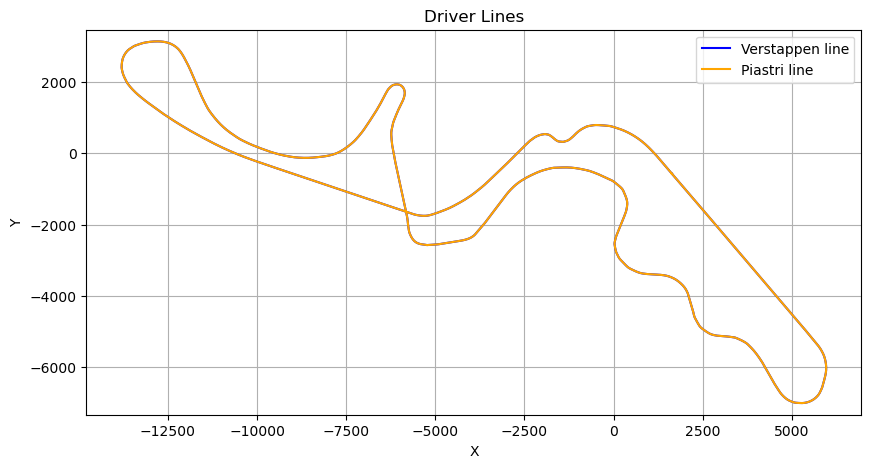

In [10]:
# Evaluate spline at many points for smoothness
u_fine = np.linspace(0, 1, 5000)
ver_x_smooth, ver_y_smooth = splev(u_fine, ver_tck)
pia_x_smooth, pia_y_smooth = splev(u_fine, pia_tck)

# Plot
plt.figure(figsize=(10,5))
plt.plot(ver_x_smooth, ver_y_smooth, color="blue", label="Verstappen line")
plt.plot(pia_x_smooth, pia_y_smooth, color="orange", label="Piastri line")

plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")  # keep aspect ratio correct
plt.title("Driver Lines")
plt.grid(True)
plt.legend()
plt.show()


In [11]:
best_laps["VER"]

Time                      0 days 01:22:10.476000
Driver                                       VER
DriverNumber                                   1
LapTime                   0 days 00:01:26.983000
LapNumber                                   16.0
Stint                                        6.0
PitOutTime                                   NaT
PitInTime                                    NaT
Sector1Time               0 days 00:00:30.387000
Sector2Time               0 days 00:00:39.355000
Sector3Time               0 days 00:00:17.241000
Sector1SessionTime        0 days 01:21:13.880000
Sector2SessionTime        0 days 01:21:53.235000
Sector3SessionTime        0 days 01:22:10.476000
SpeedI1                                    288.0
SpeedI2                                    298.0
SpeedFL                                    271.0
SpeedST                                    295.0
IsPersonalBest                              True
Compound                                    SOFT
TyreLife            

In [12]:
qualy_results = session.results
driver_positions = dict(zip(qualy_results['Abbreviation'], qualy_results['Position']))
print(driver_positions)

{'VER': 1.0, 'NOR': 2.0, 'PIA': 3.0, 'LEC': 4.0, 'RUS': 5.0, 'ANT': 6.0, 'HAD': 7.0, 'HAM': 8.0, 'ALB': 9.0, 'BEA': 10.0, 'GAS': 11.0, 'SAI': 12.0, 'ALO': 13.0, 'LAW': 14.0, 'TSU': 15.0, 'HUL': 16.0, 'BOR': 17.0, 'OCO': 18.0, 'DOO': 19.0, 'STR': 20.0}


In [13]:
for driver in ["VER", "PIA"]:

    data = {
        "driver": driver,
        "lap_time": float(best_laps[driver]["LapTime"].total_seconds()),
        "place": int(driver_positions[driver]),
        "distance": tel["Distance"].tolist(),
        "speed": tel["Speed"].tolist(),
        "throttle": tel["Throttle"].tolist(),
        "brake": tel["Brake"].tolist(),
        "location": list(zip(tel["X"].tolist(), tel["Y"].tolist(), tel["Z"].tolist())),
        "n_points": len(tel["Distance"]),
    }
    with open(f"{driver.lower()}_suzuka_2025.json", "w") as f:
        json.dump(data, f, indent=2)